<a href="https://colab.research.google.com/github/tleyden/FruitPunch_AI_Bootcamp/blob/main/FruitPunch_Capstone_Project_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Pip installs

In [ ]:
!apt install -y jq
!pip install pycocotools
!python -m pip install pyyaml==5.1
!pip install wandb -qU


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libjq1 libonig4
The following NEW packages will be installed:
  jq libjq1 libonig4
0 upgraded, 3 newly installed, 0 to remove and 20 not upgraded.
Need to get 276 kB of archives.
After this operation, 930 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libonig4 amd64 6.7.0-1 [119 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libjq1 amd64 1.5+dfsg-2 [111 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 jq amd64 1.5+dfsg-2 [45.6 kB]
Fetched 276 kB in 2s (175 kB/s)
Selecting previously unselected package libonig4:amd64.
(Reading database ... 124016 files and directories currently installed.)
Preparing to unpack .../libo

## Imports

In [ ]:
import os
from matplotlib import pyplot as plt
import cv2

from pycocotools.coco import COCO
import skimage.io as io
from pathlib import Path

import sys, distutils.core
from google.colab.patches import cv2_imshow


## Download zips from google bucket

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
if not os.path.exists("Labeled data-20211126T095740Z-001.zip"):
    !gsutil cp "gs://fruitpunch-ai-tleyden/Labeled data-20211126T095740Z-001.zip" .
if not os.path.exists("Labeled data-20211126T095740Z-002.zip"):
    !gsutil cp "gs://fruitpunch-ai-tleyden/Labeled data-20211126T095740Z-002.zip" .


Copying gs://fruitpunch-ai-tleyden/Labeled data-20211126T095740Z-001.zip...
\ [1 files][  2.0 GiB/  2.0 GiB]   59.5 MiB/s                                   
Operation completed over 1 objects/2.0 GiB.                                      
Copying gs://fruitpunch-ai-tleyden/Labeled data-20211126T095740Z-002.zip...
\ [1 files][809.6 MiB/809.6 MiB]   55.3 MiB/s                                   
Operation completed over 1 objects/809.6 MiB.                                    


In [ ]:
if not os.path.exists("labeled_data"):
    !unzip -q "Labeled data-20211126T095740Z-001.zip"
    !unzip -q "Labeled data-20211126T095740Z-002.zip"

## Re-arrange directories to match expected structure

In [ ]:
if not os.path.exists("labeled_data"):
    !mv "Labeled data" labeled_data
if not os.path.exists("labeled_data/images/test"):
    !mkdir labeled_data/images/test 
    !mv labeled_data/images/*.PNG labeled_data/images/test 

## Set path variables

In [ ]:
DATA_PATH = '/content/labeled_data/'
IMAGES_PATH = DATA_PATH + 'images/'
LABELS_PATH = DATA_PATH + 'annotations/'

# Get paths to IMAGE directories
TRAIN_IMAGES_PATH = IMAGES_PATH + 'train/'
TEST_IMAGES_PATH = IMAGES_PATH + 'test/'
VAL_IMAGES_PATH = IMAGES_PATH + 'val/'

TRAIN_LABELS = LABELS_PATH + 'instances_train.json'
TEST_LABELS = LABELS_PATH + 'instances_test_dataset.json'
VAL_LABELS = LABELS_PATH + 'instances_val.json'

## Install dependencies

In [ ]:
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities.
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

Cloning into 'detectron2'...
remote: Enumerating objects: 14651, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 14651 (delta 25), reused 45 (delta 14), pack-reused 14584
Receiving objects: 100% (14651/14651), 6.01 MiB | 5.88 MiB/s, done.
Resolving deltas: 100% (10581/10581), done.


No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 2.6 MB/s 
     |████████████████████████████████| 79 kB 6.1 MB/s 
     |████████████████████████████████| 153 kB 29.1 MB/s 
     |████████████████████████████████| 1.5 MB 49.5 MB/s 
     |████████████████████████████████| 549 kB 53.7 MB/s 
     |████████████████████████████████| 117 kB 38.8 MB/s 
     |████████████████████████████████| 96 kB 5.9 MB/s 
     |████████████████████████████████| 182 kB 58.3 MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221213-py3-none-any.whl size=61498 sha256=1f73ffc04ce9fe087b74c1f58a6edd564362c767d72466a0e16e9943f9fdbc4b
  Stored in directory: /root/.cache/pip/wheels/14/6d/5c/4fd3efe9b62aeae1e7e68204b54487df288e58e28f3d13fa1e
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144575 sha256=20c950eef57abc6e66ee29d79fabb10166a74b038aa14f8354a60b5

In [ ]:
# import detectron2 modules
from detectron2.utils.logger import setup_logger
setup_logger()
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode

import json, random
from detectron2.data.datasets import register_coco_instances

## Step 1 - analyze the data

### View training images

Displaying image: /content/labeled_data/images/train/video53_3_001081.PNG
Displaying image: /content/labeled_data/images/train/video53_2_001049.PNG
Displaying image: /content/labeled_data/images/train/videobh_1_000169.PNG
Displaying image: /content/labeled_data/images/train/video53_1_001949.PNG
Displaying image: /content/labeled_data/images/train/video53_1_003426.PNG
Displaying image: /content/labeled_data/images/train/videobh_1_003899.PNG
Displaying image: /content/labeled_data/images/train/videobh_1_001289.PNG
Displaying image: /content/labeled_data/images/train/videobh_1_003369.PNG
Displaying image: /content/labeled_data/images/train/videobh_2_000730.PNG


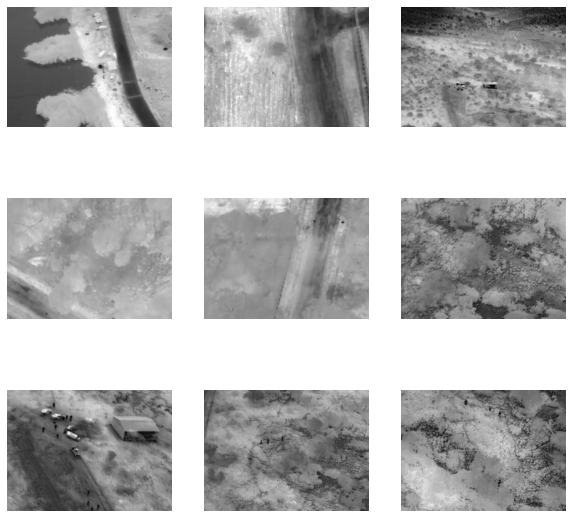

In [ ]:
# View some train images
plt.figure(figsize=(10, 10))
TRAIN_IMAGES = os.listdir(TRAIN_IMAGES_PATH)
for i in range(9):
  img_path = TRAIN_IMAGES_PATH + TRAIN_IMAGES[i]
  print(f"Displaying image: {img_path}")
  ax = plt.subplot(3, 3, i + 1)
  img = cv2.imread(img_path, )
  plt.imshow(img, cmap='gray')
  plt.axis("off")

### Visualise images and annotations

In [ ]:
# Analyse training annotations
coco = COCO(TRAIN_LABELS) # return dictionary of the dataset
img_IDs = coco.getImgIds() # get image IDs
print(f"img_IDS: {img_IDs[1100:1103]}")
imgs = coco.loadImgs(img_IDs[1100:1103]) # load images

loading annotations into memory...
Done (t=0.77s)
creating index...
index created!
img_IDS: [2579, 2580, 2581]


Displaying image: {'id': 2579, 'width': 640, 'height': 470, 'file_name': 'video53_1_002578.PNG', 'license': 0, 'flickr_url': '', 'coco_url': '', 'date_captured': 0} on ax: [<matplotlib.axes._subplots.AxesSubplot object at 0x7f42e37e2f40>
Displaying image: {'id': 2580, 'width': 640, 'height': 470, 'file_name': 'video53_1_002579.PNG', 'license': 0, 'flickr_url': '', 'coco_url': '', 'date_captured': 0} on ax: [<matplotlib.axes._subplots.AxesSubplot object at 0x7f42e385db50>
Displaying image: {'id': 2581, 'width': 640, 'height': 470, 'file_name': 'video53_1_002580.PNG', 'license': 0, 'flickr_url': '', 'coco_url': '', 'date_captured': 0} on ax: [<matplotlib.axes._subplots.AxesSubplot object at 0x7f42e38eca00>


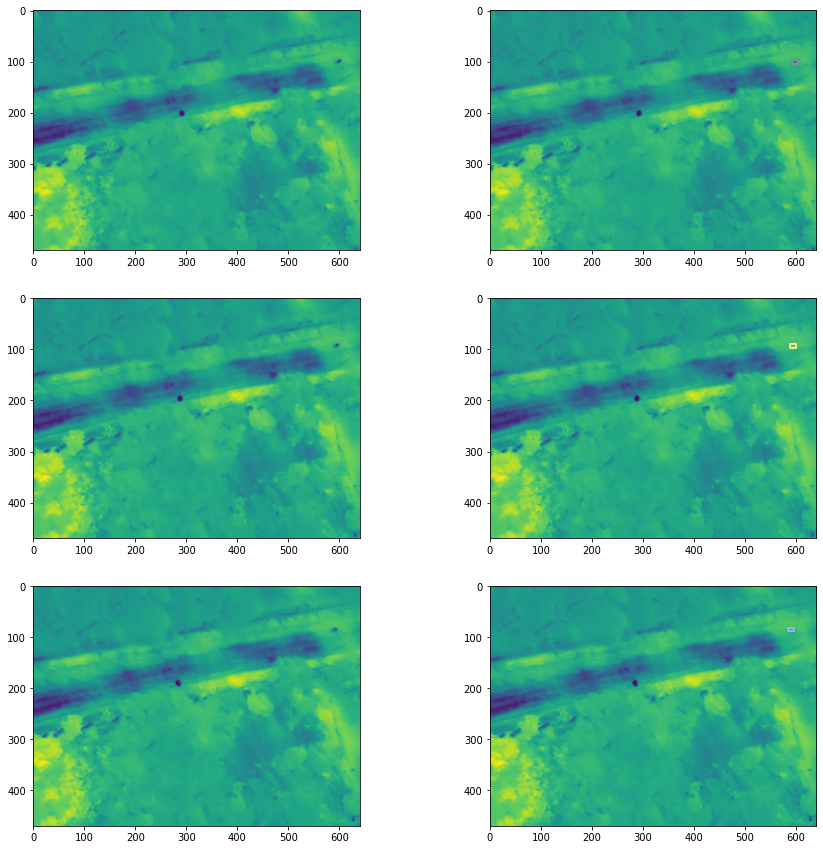

In [ ]:

# Visualise images and annotations
_, axs = plt.subplots(len(imgs), 2, figsize=(15, 15))
for img, ax in zip(imgs, axs):
    print(f"Displaying image: {img} on ax: {ax}")
    I = io.imread(Path(TRAIN_IMAGES_PATH)/img['file_name'])
    annIds = coco.getAnnIds(imgIds=[img['id']])
    anns = coco.loadAnns(annIds)
    ax[0].imshow(I)
    ax[1].imshow(I)
    plt.sca(ax[1])
    coco.showAnns(anns, draw_bbox=True)

## Visualize training data

### Register coco images

In [ ]:
register_coco_instances("my_dataset_train", {}, TRAIN_LABELS, TRAIN_IMAGES_PATH)
register_coco_instances("my_dataset_test", {}, TEST_LABELS, TEST_IMAGES_PATH)
register_coco_instances("my_dataset_val", {}, VAL_LABELS, VAL_IMAGES_PATH)

# get dictionary of filename and image ids
def get_filenames(filename_dict, json_file):
    with open(json_file) as f:
      imgs_anns = json.load(f)
    for idx in imgs_anns["images"]:
      filename = idx["file_name"]
      img_id = idx["id"]
      filename_dict[img_id] = filename
    return filename_dict

filename_dict = {}
_ = get_filenames(filename_dict, TRAIN_LABELS)
_ = get_filenames(filename_dict, TEST_LABELS)
_ = get_filenames(filename_dict, VAL_LABELS)


### Display training images

loading annotations into memory...
Done (t=0.43s)
creating index...
index created!
[12/15 01:40:02 d2.data.datasets.coco]: Loaded 13111 images in COCO format from /content/labeled_data/annotations/instances_train.json


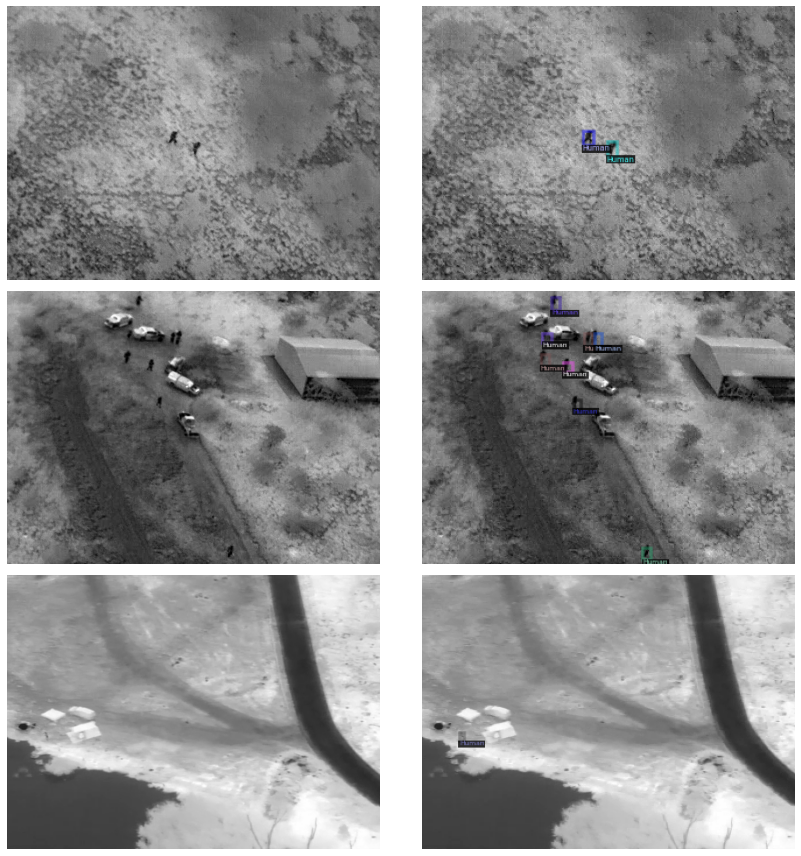

In [ ]:

coco = COCO(TRAIN_LABELS) # return dictionary of the dataset
img_IDs = coco.getImgIds() # get image IDs
imgs = coco.loadImgs(img_IDs[1100:1103]) # load images

# visualize training data
my_dataset_train_metadata = MetadataCatalog.get("my_dataset_train")
dataset_dicts = DatasetCatalog.get("my_dataset_train")

_, axs = plt.subplots(len(imgs), 2, figsize=(12, 12))
for d, ax in zip(random.sample(dataset_dicts, 3), axs):
    id = d["image_id"]
    filename = filename_dict[id]
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    # cv2_imshow(vis.get_image()[:, :, ::-1])
    ax[0].imshow(img); ax[0].axis('off')
    ax[1].imshow(vis.get_image()[:, :, ::-1]); ax[1].axis('off')
    plt.tight_layout()